# Автоэнкодеры  


Автоэнкодеры $-$ это нейросети, с помощью которых можно производить снижение  размерности. Например, если на вход поступает картинка, то автоэнкодера сжимает ее в вектор, из которого потом можно восстановить исходное изображение.

<img src="https://blog.paperspace.com/content/images/2020/01/1_oUbsOnYKX5DEpMOK3pH_lg.png" width=600>

Когда нужно выучить **более низкоразмерное представление**, скажем, **картинок**, делают так:
1. Инициализируют нейросеть, у которой есть две части $-$ Encoder и Decoder
2. Encoder принимает на вход картинку, на выход выдает эмбеддинг (вектор) размера $(1, M)$
3. Decoder принимает на вход эмбеддинг (вектор) размера $(1, M)$, и на выход возвращает картинку, которая должна быть похожа на поданное на вход Encoder'у изображение

Что такое "похожа" $-$ определяется по-разному, но для начала мы просто будем считать попиксельную разность квадратов.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

In [0]:
def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.numpy().reshape(28, 28), cmap='gray')
    plt.show()

Скачаем датасет `fashion-mnist_train.csv` с [соревнования](https://www.kaggle.com/zalando-research/fashionmnist) (можно просто запустить ячейку ниже):

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_YP-yu9JxX6iuiJbzowi47HGtq-gIVCY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_YP-yu9JxX6iuiJbzowi47HGtq-gIVCY" -O fashion-mnist_train.csv && rm -rf /tmp/cookies.txt

--2020-04-17 22:24:05--  https://docs.google.com/uc?export=download&confirm=RU5r&id=1_YP-yu9JxX6iuiJbzowi47HGtq-gIVCY
Resolving docs.google.com (docs.google.com)... 172.217.11.174, 2607:f8b0:4007:804::200e
Connecting to docs.google.com (docs.google.com)|172.217.11.174|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4k-docs.googleusercontent.com/docs/securesc/rsqcgsef41grn97e5h8t00nfftfs6ait/miikbl5171i930pil046c8bcuib2ttl1/1587162225000/14751957923043800851/06777248304116345687Z/1_YP-yu9JxX6iuiJbzowi47HGtq-gIVCY?e=download [following]
--2020-04-17 22:24:05--  https://doc-14-4k-docs.googleusercontent.com/docs/securesc/rsqcgsef41grn97e5h8t00nfftfs6ait/miikbl5171i930pil046c8bcuib2ttl1/1587162225000/14751957923043800851/06777248304116345687Z/1_YP-yu9JxX6iuiJbzowi47HGtq-gIVCY?e=download
Resolving doc-14-4k-docs.googleusercontent.com (doc-14-4k-docs.googleusercontent.com)... 172.217.14.65, 2607:f8b0:4007:803::2001
Connecting to doc-14

In [45]:
train = pd.read_csv("./fashion-mnist_train.csv")

# нормализация картинок, чтобы пиксели имели значения от 0 до 1
X = train.iloc[:,1:].values / 255
X = (X - 0.5) / 0.5

y = train.iloc[:,0].values

print(X.shape,y.shape)

(60000, 784) (60000,)


In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

In [0]:
X_train_torch = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train_torch = torch.from_numpy(y_train)

X_val_torch = torch.from_numpy(X_val).type(torch.FloatTensor)
y_val_torch = torch.from_numpy(y_val)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=100,
    shuffle=False, 
    num_workers=4
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=100,
    shuffle=False, 
    num_workers=4
)

In [52]:
idx = np.random.randint(0, len(X_train_torch))

show_torch_image(X_train_torch[idx])

In [0]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.e1 = nn.Linear(784, 28)
        self.e2 = nn.Linear(28, 250)
        
        # Эмбеддинг
        self.lv = nn.Linear(250, 10)
        
        # Decoder
        self.d1 = nn.Linear(10, 250)
        self.d2 = nn.Linear(250, 500)
        
        self.output_layer = nn.Linear(500, 784)
        
    def forward(self,x):
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        
        # здесь не обязательно сигмоида
        x = torch.sigmoid(self.lv(x))
        
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        
        x = self.output_layer(x)
        return x

In [54]:
autoencoder = AutoEncoder()
print(auoencoder)

AutoEncoder(
  (e1): Linear(in_features=784, out_features=28, bias=True)
  (e2): Linear(in_features=28, out_features=250, bias=True)
  (lv): Linear(in_features=250, out_features=10, bias=True)
  (d1): Linear(in_features=10, out_features=250, bias=True)
  (d2): Linear(in_features=250, out_features=500, bias=True)
  (output_layer): Linear(in_features=500, out_features=784, bias=True)
)


In [0]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [56]:
num_epochs = 5

losses = []

for epoch in range(num_epochs):
    for batch_idx, (X_batch, target) in enumerate(train_dataloader):
        
        y_pred = autoencoder(X_batch)

        # target нас хздесь не интересует - мы восстанавливаем сами изображения
        loss = loss_func(y_pred, X_batch)

        losses.append(loss.cpu().data.item())

        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                num_epochs,
                batch_idx * len(X_batch), 
                len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), 
                loss.cpu().data.item()), 
                end=''
            )

 Train Epoch: 5/5 [40100/48000 (84%)]	Loss: 0.073075

In [57]:
autoencoder.eval()
predictions = []

for batch_idx, (data, target) in enumerate(val_dataloader):
        y_pred = autoencoder(data)
        for prediction in y_pred:
            predictions.append(prediction)

len(predictions)

12000

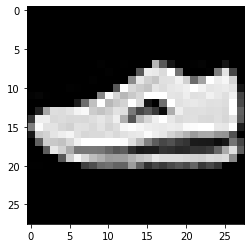

In [70]:
idx = np.random.randint(0, len(X_val_torch))

show_torch_image(X_val_torch[idx])
show_torch_image(predictions[idx].detach())

### Полезные ссылки:

- [Цикл статей на Хабре](https://habrahabr.ru/post/331382/)  
- [Курс Стэнфорда (на английском)](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Презентация (на английском) на сайте machinelearning.ru](http://www.machinelearning.ru/wiki/images/5/54/DL16_lecture_9.pdf)
- [Код всех видов автоэнкодеров на Keras](https://blog.keras.io/building-autoencoders-in-keras.html)  
- [Путь новичка](https://deeplearning4j.org/deepautoencoder)